In [1]:
import datetime
from pathlib import Path
import numpy as np
import xarray as xr
import pyproj
import ppigrf
import pygmt
import matplotlib.pyplot as plt

import verde as vd
import harmonica as hm

In [2]:
pygmt.config(
    FONT_ANNOT="11p,Helvetica,black",
    FONT_TITLE="12p,Helvetica,black",
    FONT_LABEL="10p,Helvetica,black",
    MAP_TITLE_OFFSET="0p",
    MAP_FRAME_WIDTH="2p",
)

In [3]:
def get_inclination_declination(Be, Bn, Bu, degrees=True):
    r"""
    Compute the inclination and declination angles of the IGRF
    The inclination angle is defined as the angle between the magnetic field
    vector and the horizontal plane:
    .. math::
        I = \arctan \frac{-B_u}{\sqrt{B_e^2 + B_n^2}}
    And the declination angle is defined as the azimuth of the projection of
    the magnetic field vector onto the horizontal plane (starting from the
    northing direction, positive to the east and negative to the west):
    .. math::
        D = - \arcsin \frac{B_e}{\sqrt{B_e^2 + B_n^2}}
    Parameters
    ----------
    Be : float or array
        Easting component of the IGRF magnetic vector.
    Bn : float or array
        Northing component of the IGRF magnetic vector.
    Bu : float or array
        Upward component of the IGRF magnetic vector.
    degrees : bool (optional)
        If True, the angles are returned in degrees.
        If False, the angles are returned in radians.
        Default True.
    Returns
    -------
    inclination : float or array
        Inclination angle of the IGRF magnetic vector. If ``degrees`` is True,
        then the angle is returned in degrees. If ``degrees`` is False, then
        it's returned in radians.
    declination : float or array
        Declination angle of the IGRF magnetic vector. If ``degrees`` is True,
        then the angle is returned in degrees. If ``degrees`` is False, then
        it's returned in radians.
    """
    # Compute the horizontal component of B
    horizontal_component = np.sqrt(Be**2 + Bn**2)
    if horizontal_component == 0:
        inclination = -np.sign(Bu) * np.pi /2
        declination = 0
    else:
        # Compute the two angles
        inclination = np.arctan(-Bu / horizontal_component)
        declination = np.arcsin(Be / horizontal_component)
    # Convert to degrees if needed
    if degrees:
        inclination = np.degrees(inclination)
        declination = np.degrees(declination)
    return inclination, declination

In [4]:
data_dir = Path("..") / "data"
grd_file = data_dir / "Mount Milligan_MTF.GRD"

In [5]:
grid = hm.load_oasis_montaj_grid(grd_file)
grid

<xarray.DataArray (northing: 337, easting: 816)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * easting   (easting) float64 3.751e+05 3.752e+05 ... 4.565e+05 4.566e+05
  * northing  (northing) float64 6.093e+06 6.093e+06 ... 6.126e+06 6.126e+06
Attributes: (12/23)
    n_bytes_per_element:  1028
    sign_flag:            2
    shape_e:              816
    shape_v:              337
    ordering:             1
    spacing_e:            100.0
    ...                   ...
    grid_min:             -1.0000000331813535e+32
    grid_max:             -1.0000000331813535e+32
    grid_median:          -1.0000000331813535e+32
    grid_mean:            -1.0000000331813535e+32
    grid_variance:        0.0
    process_flag:         0

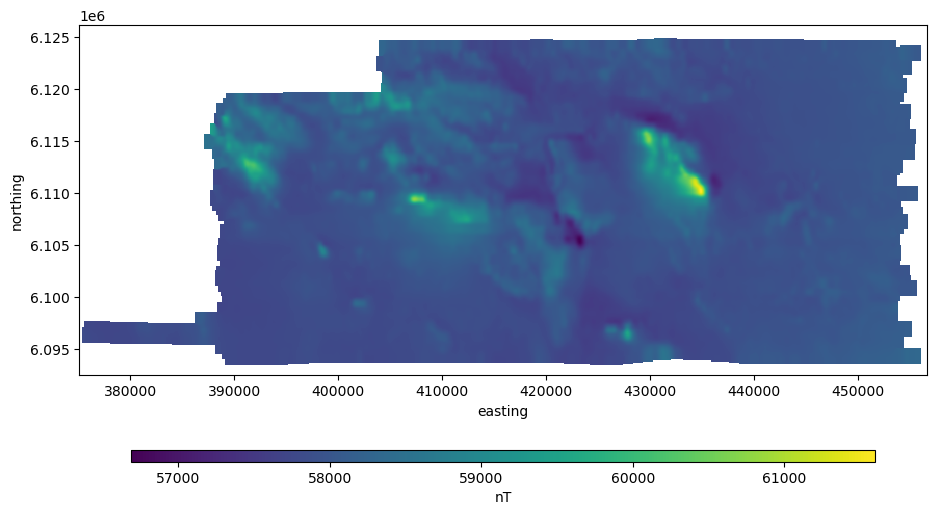

In [6]:
plt.figure(figsize=(12, 6.5))
tmp = grid.plot(add_colorbar=False, cmap="viridis")
plt.colorbar(tmp, orientation="horizontal", label="nT", aspect=64, shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()

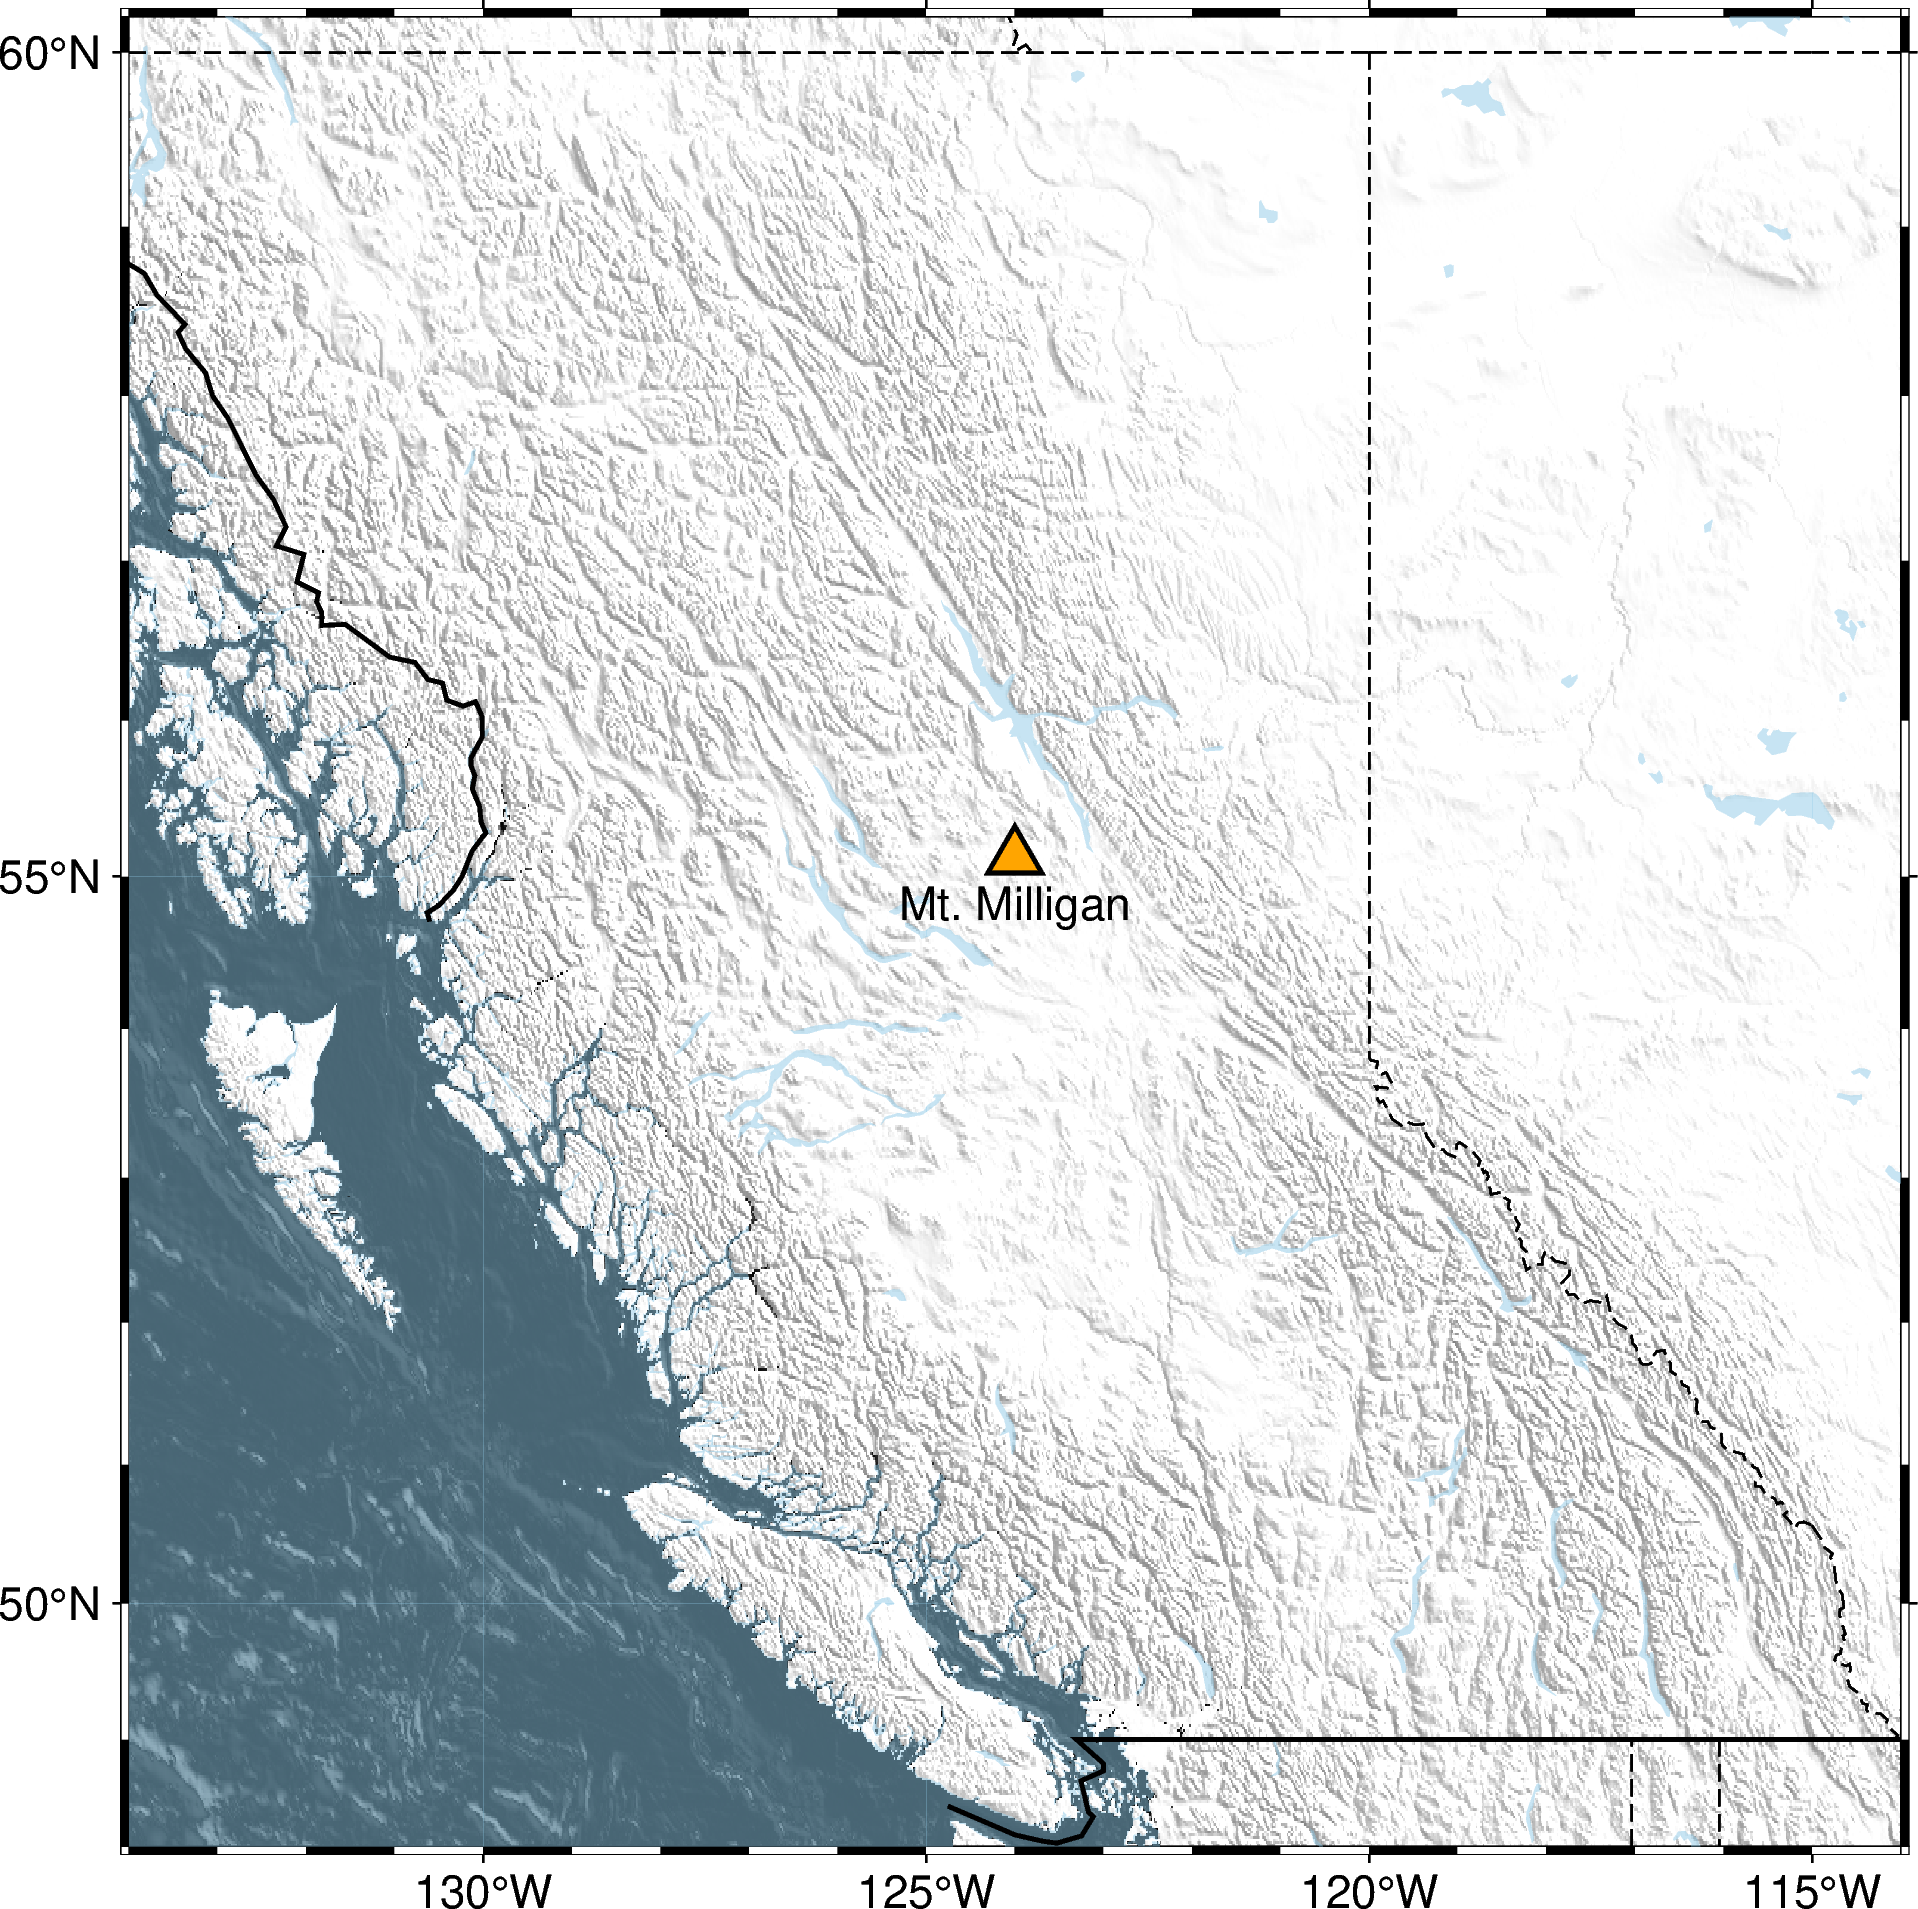

In [7]:
fig = pygmt.Figure()

mt_milligan = (-124.000870, 55.124114)

large_region = (-134, -114, 48.2, 60.2)

mercator = "M15c"

pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_01m",
    projection=mercator,
    shading="+a45+nt0.7",
    region=large_region,
    cmap=True,
    frame="af",
)
fig.coast(
    water="#8fcae7",
    transparency=50,
)
fig.coast(borders="1/1p")
fig.coast(borders="2/0.5p,--")

fig.plot(
    x=mt_milligan[0],
    y=mt_milligan[1],
    projection=mercator,
    style="t15p",
    fill="orange",
    pen="1p,black",
)
fig.text(
    text="Mt. Milligan",
    x=mt_milligan[0],
    y=mt_milligan[1] - 0.3,
    projection=mercator,
)

fig.show()

In [8]:
projection = pyproj.Proj(proj="utm", zone=10, ellps="WGS84")
projection

<Other Coordinate Operation Transformer: utm>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

(375131.0, 456631.0, 6092540.0, 6126140.0)
(-124.96518880466827, -123.67760664182295, 54.96412676020528, 55.279796459259494)


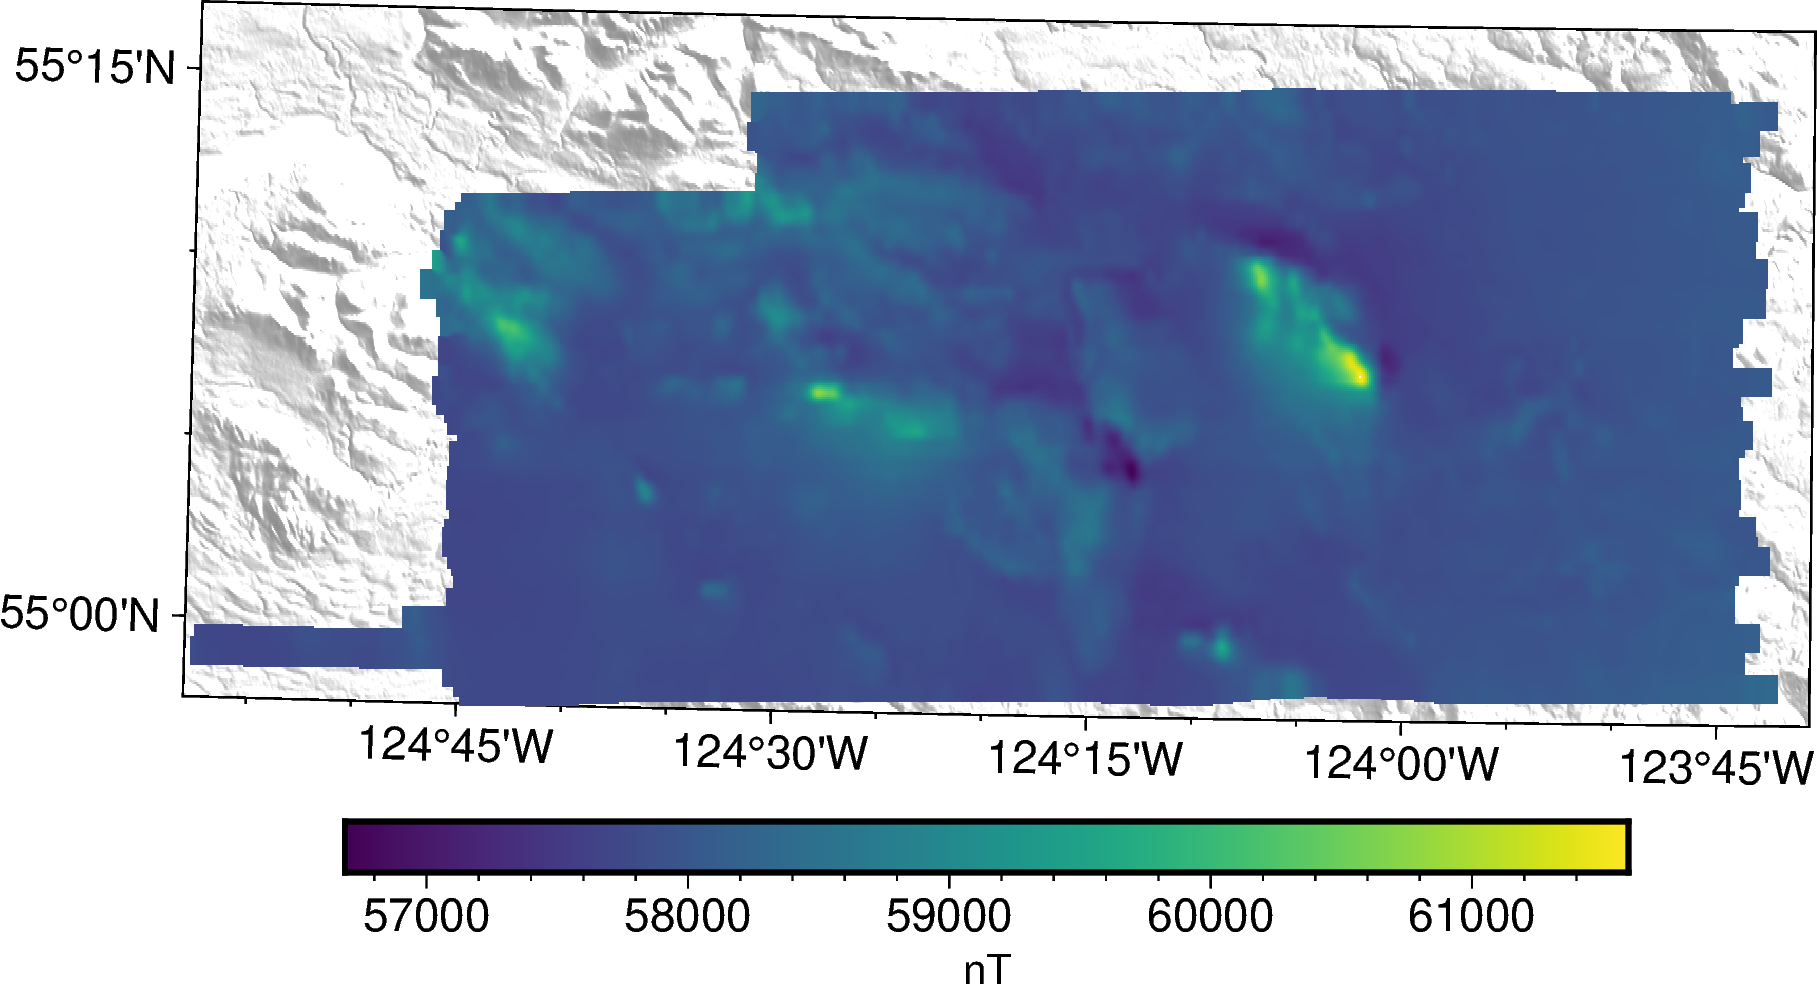

In [9]:
fig = pygmt.Figure()

# Get region of the grid in UTM coordinates
region = vd.get_region((grid.easting.values, grid.northing.values))
print(region)

# Get boundaries of the region in geographic coordinates
region_deg = vd.project_region(
    region,
    projection=lambda easting, northing: projection(easting, northing, inverse=True)
)
print(region_deg)

# Get UTM zone 10 projection
zone = 10
scale = "1:600000"
utm_projection = f"u{zone}/{scale}"

# Basemap
fig.basemap(projection=utm_projection, region=region_deg, frame="af")

# Relief and water
pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_03s",
    # projection=utm_projection,
    shading="+a45+nt0.7",
    #region=region,
    cmap=True,
)
fig.coast(
    water="#8fcae7",
    transparency=50,
)
fig.coast(borders="1/1p", resolution="h")
fig.coast(borders="2/0.5p,--", resolution="h")

# Plot projected grid
# (need to use the linear "x" projection since it's already projected)
# (need to pass the region of the grid in projected coordinates!)
vmin = grid.min().values
vmax = grid.max().values
pygmt.makecpt(cmap="viridis", series=[vmin, vmax], no_bg=True)
fig.grdimage(
    grid,
    nan_transparent=True,
    projection=f"x{scale}",
    region=region,
    cmap=True,
)
fig.colorbar(frame='af+l"nT"')

fig.show()

## Compute IGRF and total field anomaly

In [10]:
import datetime

date = datetime.datetime(year=1991, month=9, day=14)
height_km = 120 * 1e-3

In [11]:
lon_center = np.mean(region_deg[:2])
lat_center = np.mean(region_deg[2:])
lon_center, lat_center

(-124.32139772324561, 55.12196160973239)

In [12]:
b_e, b_n, b_u = tuple(b_i.ravel()[0] for b_i in ppigrf.igrf(lon_center, lat_center, height_km, date))

igrf = np.sqrt(b_e**2 + b_n**2 + b_u**2)
igrf

58167.13071596097

In [13]:
tf_anomaly = grid - igrf
tf_anomaly

<xarray.DataArray (northing: 337, easting: 816)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * easting   (easting) float64 3.751e+05 3.752e+05 ... 4.565e+05 4.566e+05
  * northing  (northing) float64 6.093e+06 6.093e+06 ... 6.126e+06 6.126e+06

(375131.0, 456631.0, 6092540.0, 6126140.0)
(-124.96518880466827, -123.67760664182295, 54.96412676020528, 55.279796459259494)


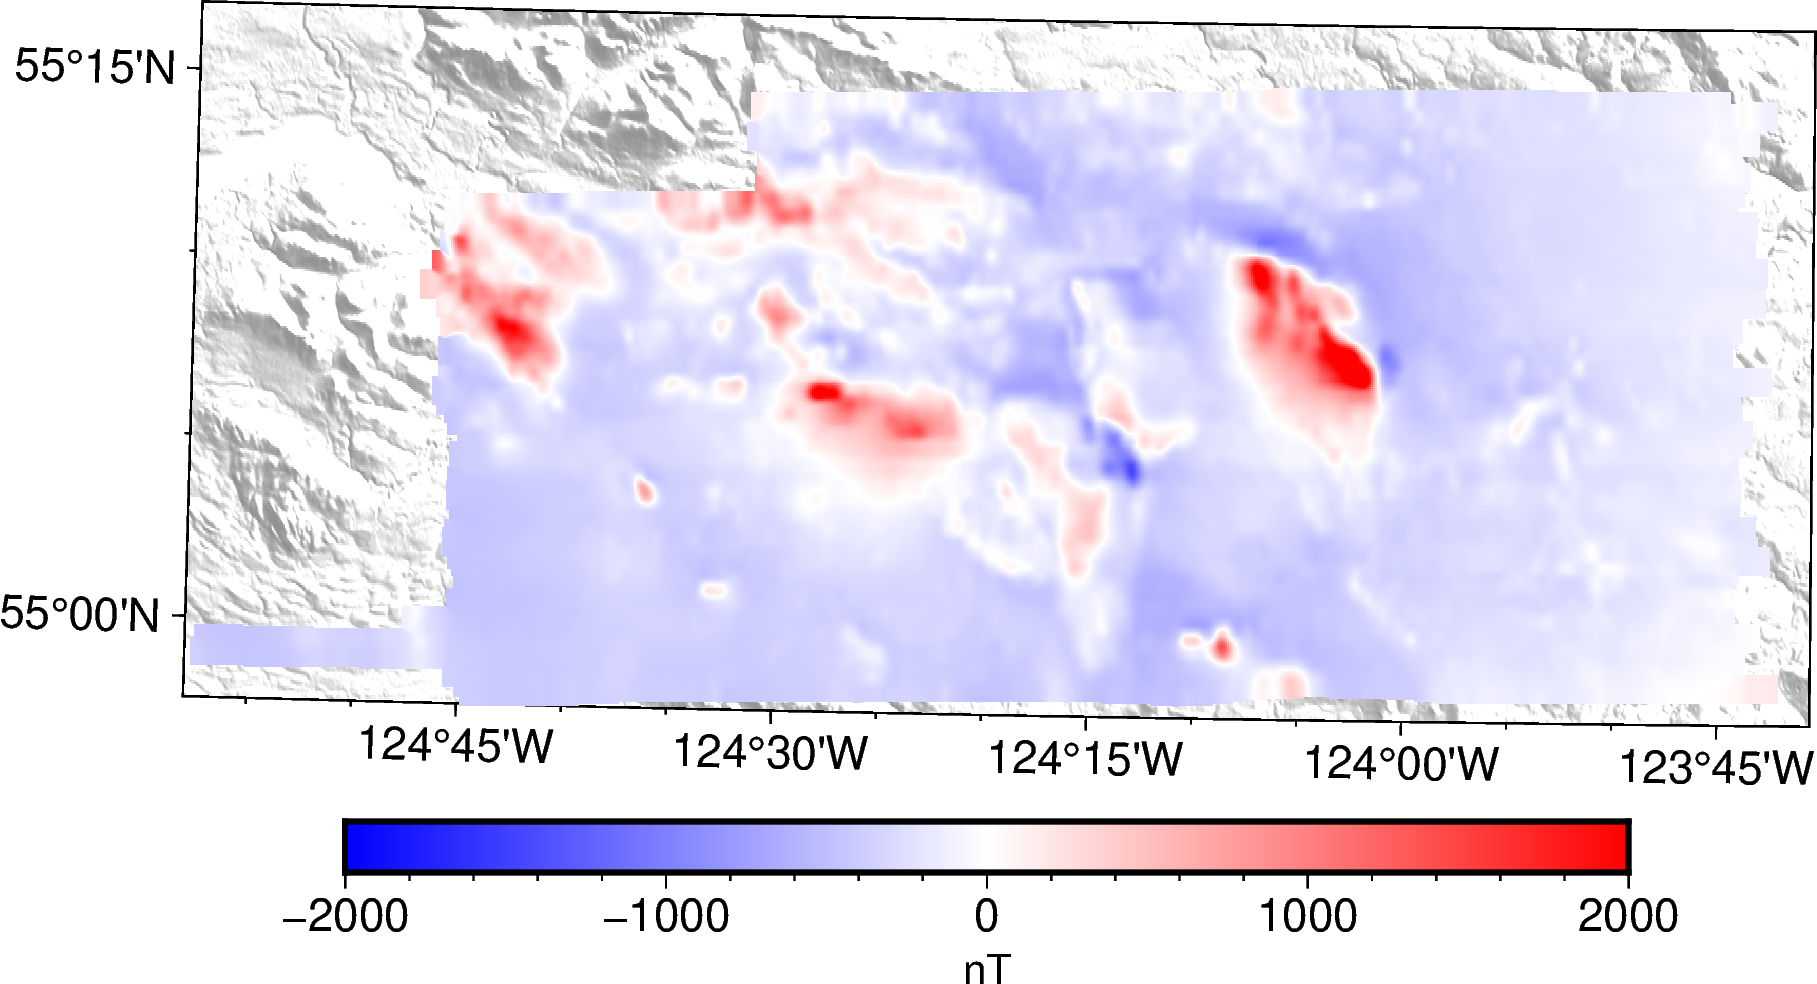

In [14]:
fig = pygmt.Figure()

# Get region of the grid in UTM coordinates
region = vd.get_region((tf_anomaly.easting.values, tf_anomaly.northing.values))
print(region)

# Get boundaries of the region in geographic coordinates
region_deg = vd.project_region(
    region,
    projection=lambda easting, northing: projection(easting, northing, inverse=True)
)
print(region_deg)

# Get UTM zone 10 projection
zone = 10
scale = "1:600000"
utm_projection = f"u{zone}/{scale}"

# Basemap
fig.basemap(projection=utm_projection, region=region_deg, frame="af")

# Relief and water
pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_03s",
    # projection=utm_projection,
    shading="+a45+nt0.7",
    #region=region,
    cmap=True,
)
fig.coast(
    water="#8fcae7",
    transparency=50,
)
fig.coast(borders="1/1p", resolution="h")
fig.coast(borders="2/0.5p,--", resolution="h")

# Plot projected grid
# (need to use the linear "x" projection since it's already projected)
# (need to pass the region of the grid in projected coordinates!)
pygmt.makecpt(cmap="polar", series=[-2000, 2000], background=True)
fig.grdimage(
    tf_anomaly,
    nan_transparent=True,
    projection=f"x{scale}",
    region=region,
    cmap=True,
)
fig.colorbar(frame='af+l"nT"')

fig.show()